<h1 style = "font-size:60px; font-family:Georgia ; font-weight : normal; background-color: #f5f5f5 ; color : #00bbf9; text-align: center; border-radius: 100px 100px;">Liver Disease Analysis: EDA➡️SMOTE➡️OPTUNA➡️SHAP</h1>

# Table of Contents

* [1. Problem Statement](#1)
    
* [2. Importing Libraries and Read In Dataset](#2)

* [3. Exploratory Data Analysis (EDA)](#3)

* [3.1 Univariate Analysis and Visualization of Dataset Features](#31)

* [3.2 Bivariate Analysis and Visualization of Dataset Features](#32)

* [3.3 Multivariate Analysis and Visualization with PCA](#33)
    
* [4. Balance Dataset with SMOTE](#4)

* [5. Model Creation and Hyperparameter Optimization with OPTUNA](#5)

* [6. Model Evaluation on Test Set and Explination with SHAP](#6)

* [7. Conclusion](#7)

<a id="1"></a>
# 1. Problem Statement

<p>
    According to the Centers for Disease Control and Prevention (CDC): <quote>
    Hepatitis C is a liver infection caused by the hepatitis C virus (HCV). Hepatitis C is spread through contact with blood from an infected person. Today, most people become infected with the hepatitis C virus by sharing needles or other equipment used to prepare and inject drugs. For some people, hepatitis C is a short-term illness, but for more than half of people who become infected with the hepatitis C virus, it becomes a long-term, chronic infection. Chronic hepatitis C can result in serious, even life-threatening health problems like cirrhosis and liver cancer. People with chronic hepatitis C can often have no symptoms and don’t feel sick. When symptoms appear, they often are a sign of advanced liver disease. There is no vaccine for hepatitis C. The best way to prevent hepatitis C is by avoiding behaviors that can spread the disease, especially injecting drugs. Getting tested for hepatitis C is important, because treatments can cure most people with hepatitis C in 8 to 12 weeks.
    </quote>
    </p>
<p>Source - <a href="https://www.cdc.gov/hepatitis/hcv/index.htm#:~:text=Hepatitis%20C%20is%20a%20liver,to%20prepare%20and%20inject%20drugs.">cdc.gov - Viral Hepatitis</a></p>
<br/>
<p><strong>Creating a pblueictive model that could perform early detection of Hepatits C and other liver diseases would allow people to quickly and easily determine their risk/get treatment.</strong></p>
<p>Dataset Source - <a href="https://archive.ics.uci.edu/ml/datasets/HCV+data">UCI Machine Learning Repository</a></p>

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.1 MB/s eta 0:00:00


In [ ]:
pip install seaborn==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [ ]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

<a id="2"></a>
# 2. Importing Libraries and Read in Dataset

In [ ]:
#Imports needed libraries
import numpy as np #linear algebra
import pandas as pd #data manipulation
import matplotlib.pyplot as plt #data viz
from matplotlib.gridspec import GridSpec #data viz
from matplotlib.animation import FuncAnimation #animation
import seaborn as sns #data viz
#data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA #principle component analysis
from IPython.display import HTML #display gif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #balance classes
import optuna
#models to try out
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import graphviz #graph of model
#metrics
from sklearn import metrics
#shap
import shap
import warnings #warnings
warnings.filterwarnings('ignore') #Hides warning popups

In [ ]:
#Reads in dataset
data = pd.read_csv('/content/HepatitisCdata.csv', index_col=0)
data.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


<h3>About Each Attribute</h3>
<ul>
<li>Category: The target feature. values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis'</li>
<li>Age: age of the patient in years</li>
<li>Sex: sex of the patient ('f'=female, 'm'=male)</li>
<li>ALB: amount of albumin in patient's blood</li>
<li>ALP: amount of alkaline phosphatase in patient's blood</li>
<li>ALT: amount of alanine transaminase in patient's blood</li>
<li>AST: amount of aspartate aminotransferase in patient's blood</li>
<li>BIL: amount of bilirubin in patient's blood</li>
<li>CHE: amount of cholinesterase in patient's blood</li>
<li>CHOL: amount of cholesterol in patient's blood</li>
<li>CREA: amount of creatine in patient's blood</li>
<li>GGT: amount of gamma-glutamyl transferase in patient's blood</li>
<li>PROT: amount of protien in patient's blood</li>
</ul>

<a id="3"></a>
# 3. Exploratory Data Analysis (EDA)

In [ ]:
#displays shape of the dataset
data.shape #615 rows, 13 columns

(615, 13)

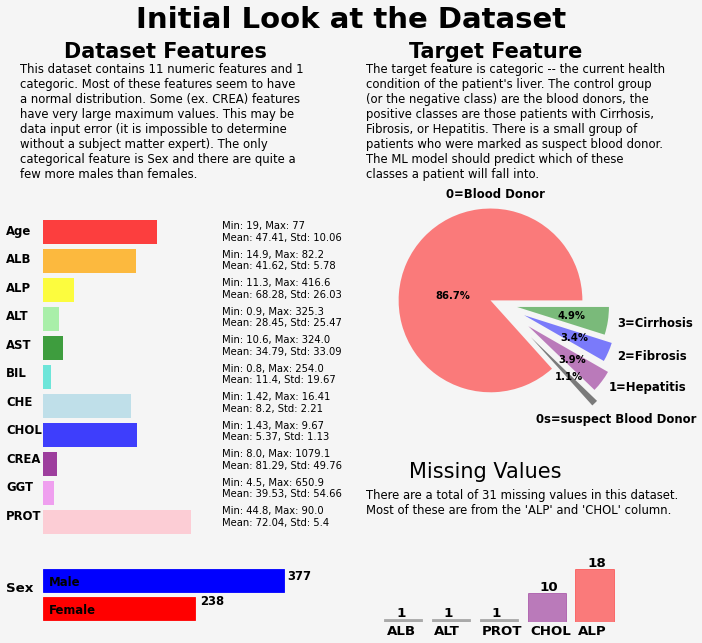

In [ ]:
#Visualizes Basic Data Statistics
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=16, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')

ax1_1 = fig.add_subplot(gs[1:2, 1:4]) #top left
ax1_2 = fig.add_subplot(gs[2:3, 1:4])
ax1_3 = fig.add_subplot(gs[3:4, 1:4])
ax1_4 = fig.add_subplot(gs[4:5, 1:4])
ax1_5 = fig.add_subplot(gs[5:6, 1:4])
ax1_6 = fig.add_subplot(gs[6:7, 1:4])
ax1_7 = fig.add_subplot(gs[7:8, 1:4])
ax1_8 = fig.add_subplot(gs[8:9, 1:4])
ax1_9 = fig.add_subplot(gs[9:10, 1:4])
ax1_10 = fig.add_subplot(gs[10:11, 1:4])
ax1_11 = fig.add_subplot(gs[11:12, 1:4])



ax2 = fig.add_subplot(gs[13:15, 1:5]) #bottom left
ax3 = fig.add_subplot(gs[:8, 6:]) #top right
ax4 = fig.add_subplot(gs[13:15, 6:]) #bottom right

# axes list
axes = [ ax1_1, ax1_2, ax1_3, ax1_4, ax1_5, ax1_6,
        ax1_7, ax1_8, ax1_9, ax1_10, ax1_11, ax2, ax3, ax4]


# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)


#------------------------------------------------------------
#Plots bar charts of numeric columns in top left
import matplotlib.pyplot as plt

top_left_axes = [ax1_1, ax1_2, ax1_3, ax1_4, ax1_5, ax1_6, ax1_7, ax1_8, ax1_9, ax1_10, ax1_11]
colors = ['blue', 'orange', 'yellow', 'lightgreen', 'green', 'turquoise', 'lightblue', 'blue', 'purple', 'violet', 'pink']
y = 0.805

for ax, color, column in zip(top_left_axes, colors, list(data.describe().columns)):
    ax.barh(y=0, width=data[column].mean(), height=0.6, color=color, alpha=0.75)  # Change to horizontal bar graph
    ax.set_xlim(0, data[column].max() + 1)  # Adjust x-axis limit to accommodate data range
    ax.spines['right'].set_visible(False)  # Remove right spine
    ax.spines['top'].set_visible(False)  # Remove top spine

    fig.text(0.07, y, column, {'fontname': 'Georgia', 'weight': 'bold', 'color': 'black', 'size': 14})
    stats_text = "Min: {}, Max: {}\nMean: {}, Std: {}".format(round(data[column].min(), 2),
                                                              round(data[column].max(), 2),
                                                              round(data[column].mean(), 2),
                                                              round(data[column].std(), 2))
    fig.text(0.22, y - 0.01, stats_text, {'fontname': 'Georgia', 'weight': 'normal', 'color': 'black', 'size': 12})
    y -= 0.0475



#ax1 title
fig.text(0.11, 1.1, 'Dataset Features', {'font':'Georgia',  'color': 'black', 'size':25})
fig.text(0.08, 0.9, "This dataset contains 11 numeric features and 1\ncategoric." +\
         " Most of these features seem to have\na normal distribution. " +\
         "Some (ex. CREA) features\nhave very large maximum values. " +\
         "This may be\ndata input error (it is impossible to determine\nwithout a subject matter expert). " +\
         "The only\ncategorical feature is Sex and there are quite a\nfew more males than females.",
        {'font':'Georgia', 'weight':'normal','color': 'black', 'size':14})


#------------------------------------------------------------
#plots sex in bottom left
sex_data = data.groupby('Sex').Sex.count()
ax2_plot = ax2.barh(sex_data.index, sex_data.values)
for i, rect in enumerate(ax2_plot):
    if i == 0:
        rect.set_color('blue')
    else:
        rect.set_color('blue')


fig.text(0.07, 0.21, 'Sex', {'font':'Georgia',  'color': 'black', 'size':16})
fig.text(0.1, 0.22, 'Male', {'font':'Georgia',  'color': 'black', 'size':14})
fig.text(0.1, 0.1725, 'Female', {'font':'Georgia',  'color': 'black', 'size':14})
fig.text(0.265, 0.23, sex_data['m'], {'font':'Georgia',  'color': 'black', 'size':14})
fig.text(0.205, 0.1875, sex_data['f'], {'font':'Georgia',  'color': 'black', 'size':14})


#------------------------------------------------------------
#plots split of target feature in pie chart
ax3_plot = ax3.pie(data.groupby('Category').Category.count().values,
                   labels=data.groupby('Category').Category.count().index,
                    autopct='%1.1f%%', explode=[0.1, 0.5, 0.4, 0.3, 0.2],
                   colors=['blue', 'black', 'purple', 'blue', 'green'])

for piece in ax3_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax3_plot[1]):
    text.set_weight('bold')
    text.set_size(14)
    if i == 0:
        text.set_y(1.2)
        text.set_x(0.5)
    if i == 1:
        text.set_y(-1.25)
        text.set_x(0.4)
for i, text in enumerate(ax3_plot[2]):
    text.set_weight('bold')
    text.set_size(12)
    if i == 0:
        text.set_y(0.1)
        text.set_x(-0.5)

fig.text(0.35, 1.1, 'Target Feature',  {'font':'Georgia',  'color': 'black', 'size':25})
fig.text(0.32, 0.9,
        "The target feature is categoric -- the current health\ncondition of the patient's liver. " +\
         "The control group\n(or the negative class) are the blood donors, the\npositive classes " +\
         "are those patients with Cirrhosis,\nFibrosis, or Hepatitis. There is a small group of " +\
         "\npatients who were marked as suspect blood donor.\nThe ML model should pblueict which of these\n" +\
         "classes a patient will fall into.",
        {'font':'Georgia', 'weight':'normal','color': 'black', 'size':14})



#------------------------------------------------------------
#plot null values in barchart
null_data = data.isnull().sum()[data.isnull().sum() > 0].sort_values()
ax4_plot = ax4.bar(null_data.index, null_data.values)
for i, rect in enumerate(ax4_plot):
    height = rect.get_height()
    ax4.text((rect.get_x() + (rect.get_width() / 2.)) - 0.35, -4, null_data.index[i],
           {'font':'Georgia',  'color': 'black', 'size':16})
    ax4.text((rect.get_x() + (rect.get_width() / 2.)) - 0.15, 1. + height, null_data.values[i],
           {'font':'Georgia',  'color': 'black', 'size':16})
    if i < 3:
        rect.set_color('darkgrey')
    elif i == 3:
        rect.set_color('purple')
        rect.set_alpha(0.5)
    else:
        rect.set_color('blue')
        rect.set_alpha(0.5)
fig.text(0.35, 0.4, 'Missing Values', {'font':'Georgia','color': 'black', 'size':25})
fig.text(0.32, 0.34,
        "There are a total of 31 missing values in this dataset.\n" +\
         "Most of these are from the 'ALP' and 'CHOL' column.",
        {'font':'Georgia', 'weight':'normal','color': 'black', 'size':14})

#-----------------------------------------------------------------
fig.text(0.16,1.15,'Initial Look at the Dataset', {'font':'Georgia',  'color': 'black', 'size':35})
plt.show()

<a id="31"></a>
# 3.1 Univariate Analysis and Visualization of Dataset Features

In [ ]:
#maps target feature
target_map = {'0=Blood Donor': 'Healthy',
             '0s=suspect Blood Donor': 'Healthy', #suspects are binned with blood donors for simplicity
             '1=Hepatitis': 'Hepatitis',
             '2=Fibrosis': 'Fibrosis',
             '3=Cirrhosis': 'Cirrhosis'}

data['Category'] = data.Category.map(target_map)

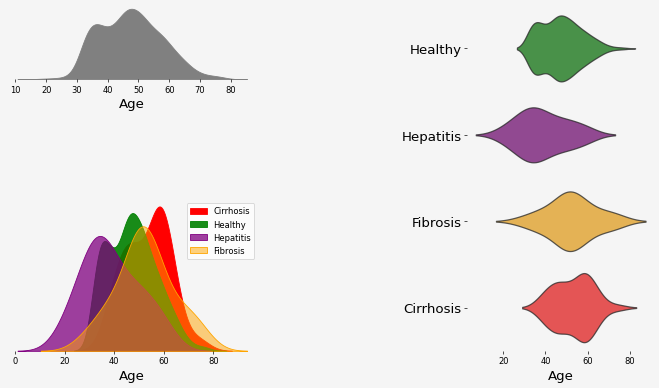

In [ ]:
#plots univariate analysis of age
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('Age', data=data, ax=ax1, shade=True, color='grey', alpha=1)
ax1.set_xlabel('Age', {'font':'Georgia', 'fontsize':16, 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('Age', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue', alpha=1, label='Cirrhosis')
sns.kdeplot('Age', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green', alpha=0.9, label='Healthy')
sns.kdeplot('Age', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple', alpha=0.75, label='Hepatitis')
sns.kdeplot('Age', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange', alpha=0.5, label='Fibrosis')

ax2.legend()
ax2.set_xlabel('Age', {'font':'Georgia', 'fontsize':16, 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='Age', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16, 'color':'black'})
ax3.set_xlabel('Age', {'font':'Georgia', 'fontsize':16, 'color':'black'})
#----------------------------------------------------------------------------
#axes titles
#ax1


plt.show()

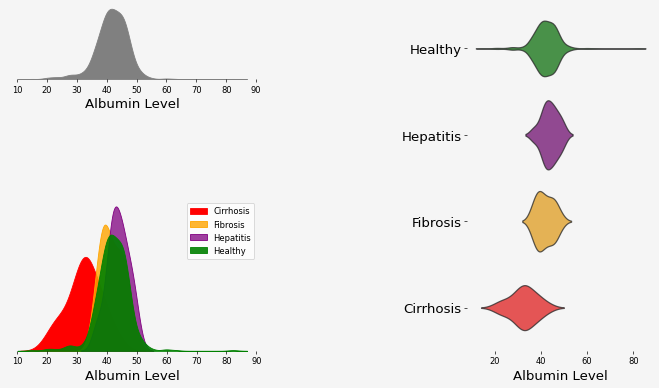

In [ ]:
#plots univariate analysis of ALB
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('ALB', data=data, ax=ax1, shade=True, color='grey', alpha=1)
ax1.set_xlabel('Albumin Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('ALB', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue', alpha=1, label='Cirrhosis')
sns.kdeplot('ALB', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange', alpha=0.8, label='Fibrosis')
sns.kdeplot('ALB', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple', alpha=0.75, label='Hepatitis')
sns.kdeplot('ALB', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green', alpha=0.9, label='Healthy')


ax2.legend()
ax2.set_xlabel('Albumin Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='ALB', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16 , 'color':'black'})
ax3.set_xlabel('Albumin Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})
#-------------------------------------------------------------------


plt.show()

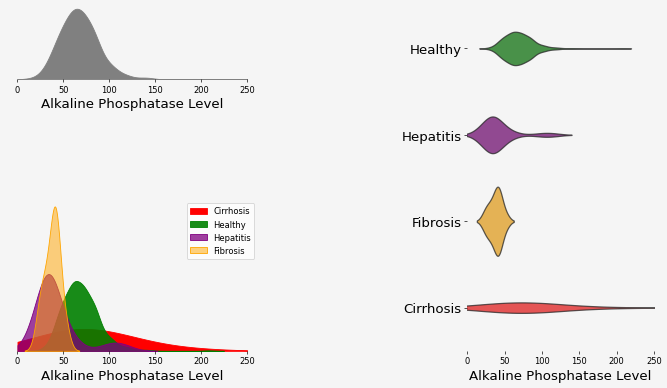

In [ ]:
#plots univariate analysis of ALP
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('ALP', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0, 250])
ax1.set_xlabel('Alkaline Phosphatase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('ALP', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue',
            alpha=1, label='Cirrhosis', clip=[0, 250])
sns.kdeplot('ALP', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0, 250])
sns.kdeplot('ALP', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0, 250])
sns.kdeplot('ALP', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0, 250])

ax2.legend()
ax2.set_xlabel('Alkaline Phosphatase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='ALP', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.set_xlim(0, 250)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16 , 'color':'black'})
ax3.set_xlabel('Alkaline Phosphatase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})
#----------------------------------------------------


plt.show()

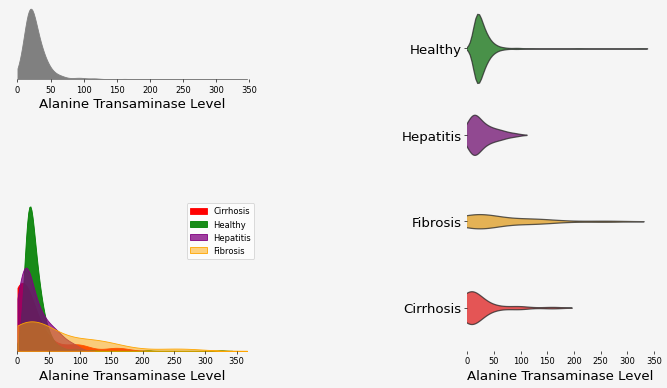

In [ ]:
#plots univariate analysis of ALT
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('ALT', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,500])
ax1.set_xlabel('Alanine Transaminase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('ALT', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue',
            alpha=1, label='Cirrhosis', clip=[0,500])
sns.kdeplot('ALT', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,500])
sns.kdeplot('ALT', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,500])
sns.kdeplot('ALT', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,500])

ax2.legend()
ax2.set_xlabel('Alanine Transaminase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='ALT', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
ax3.set_xlim(0,350)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16 , 'color':'black'})
ax3.set_xlabel('Alanine Transaminase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})
#--------------------------------------------------------


plt.show()

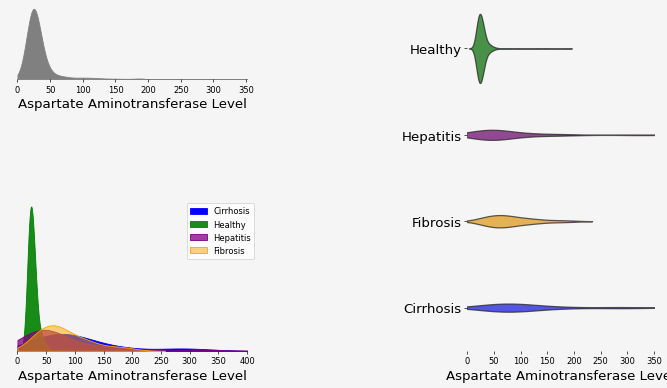

In [ ]:
#plots univariate analysis of AST
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('AST', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,400])
ax1.set_xlabel('Aspartate Aminotransferase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('AST', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue',
            alpha=1, label='Cirrhosis', clip=[0,400])
sns.kdeplot('AST', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,400])
sns.kdeplot('AST', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,400])
sns.kdeplot('AST', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,400])

ax2.legend()
ax2.set_xlabel('Aspartate Aminotransferase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='AST', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
ax3.set_xlim(0,350)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16 , 'color':'black'})
ax3.set_xlabel('Aspartate Aminotransferase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})
#--------------------------------------------------------

plt.show()

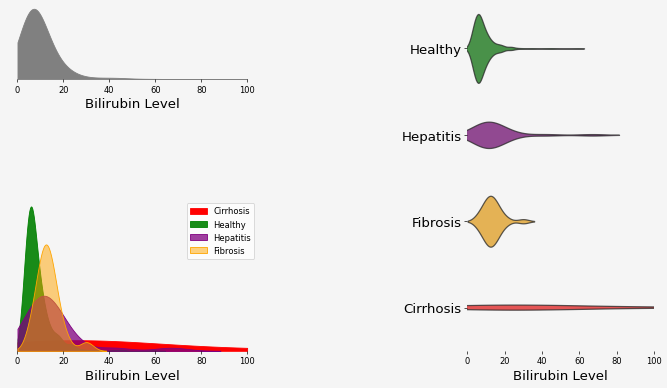

In [ ]:
#plots univariate analysis of BIL
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('BIL', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,100])
ax1.set_xlabel('Bilirubin Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('BIL', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue',
            alpha=1, label='Cirrhosis', clip=[0,100])
sns.kdeplot('BIL', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,100])
sns.kdeplot('BIL', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,100])
sns.kdeplot('BIL', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,100])

ax2.legend()
ax2.set_xlabel('Bilirubin Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='BIL', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
ax3.set_xlim(0,100)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16 , 'color':'black'})
ax3.set_xlabel('Bilirubin Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})
#--------------------------------------------------------



plt.show()

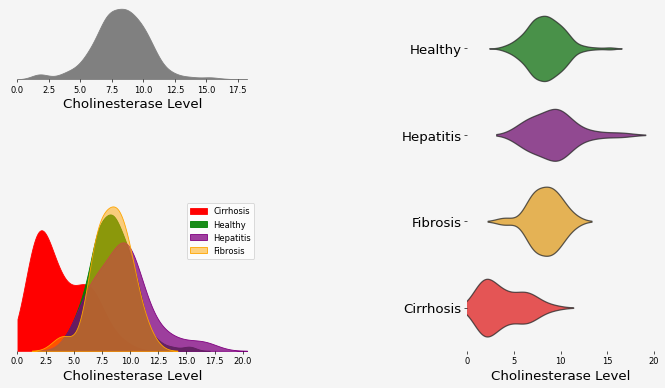

In [ ]:
#plots univariate analysis of CHE
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('CHE', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,400])
ax1.set_xlabel('Cholinesterase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('CHE', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue',
            alpha=1, label='Cirrhosis', clip=[0,400])
sns.kdeplot('CHE', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,400])
sns.kdeplot('CHE', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,400])
sns.kdeplot('CHE', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,400])

ax2.legend()
ax2.set_xlabel('Cholinesterase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='CHE', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
ax3.set_xlim(0,20)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16 , 'color':'black'})
ax3.set_xlabel('Cholinesterase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})
#--------------------------------------------------------
#axes titles



plt.show()

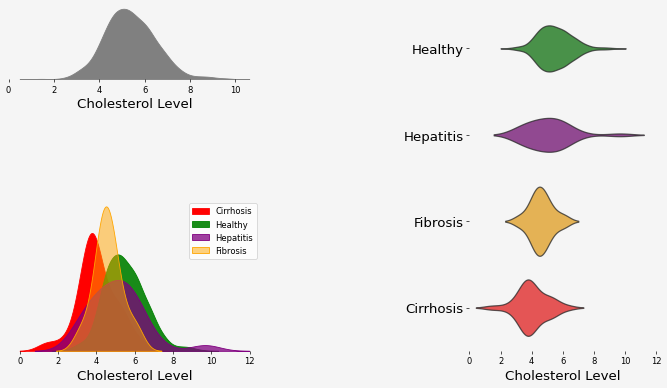

In [ ]:
#plots univariate analysis of CHOL
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('CHOL', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,400])
ax1.set_xlabel('Cholesterol Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('CHOL', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue',
            alpha=1, label='Cirrhosis', clip=[0,400])
sns.kdeplot('CHOL', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,400])
sns.kdeplot('CHOL', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,400])
sns.kdeplot('CHOL', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,400])

ax2.legend()
ax2.set_xlabel('Cholesterol Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='CHOL', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
ax3.set_xlim(0,12)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16 , 'color':'black'})
ax3.set_xlabel('Cholesterol Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})
#--------------------------------------------------------


plt.show()

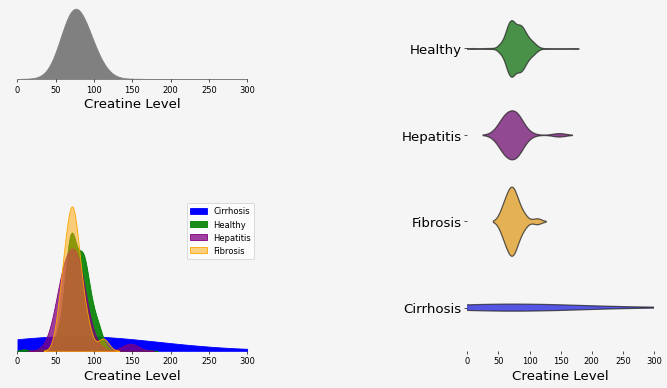

In [ ]:
#plots univariate analysis of CREA
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('CREA', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,300])
ax1.set_xlabel('Creatine Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('CREA', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue',
            alpha=1, label='Cirrhosis', clip=[0,300])
sns.kdeplot('CREA', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,300])
sns.kdeplot('CREA', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,300])
sns.kdeplot('CREA', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,300])

ax2.legend()
ax2.set_xlabel('Creatine Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='CREA', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
ax3.set_xlim(0,300)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16 , 'color':'black'})
ax3.set_xlabel('Creatine Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})
#--------------------------------------------------------


plt.show()

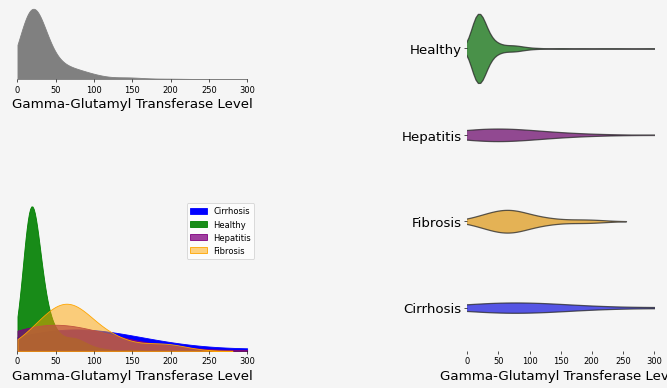

In [ ]:
#plots univariate analysis of GGT
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('GGT', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,300])
ax1.set_xlabel('Gamma-Glutamyl Transferase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('GGT', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue',
            alpha=1, label='Cirrhosis', clip=[0,300])
sns.kdeplot('GGT', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,300])
sns.kdeplot('GGT', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,300])
sns.kdeplot('GGT', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,300])

ax2.legend()
ax2.set_xlabel('Gamma-Glutamyl Transferase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='GGT', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
ax3.set_xlim(0,300)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16 , 'color':'black'})
ax3.set_xlabel('Gamma-Glutamyl Transferase Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})
#--------------------------------------------------------


plt.show()

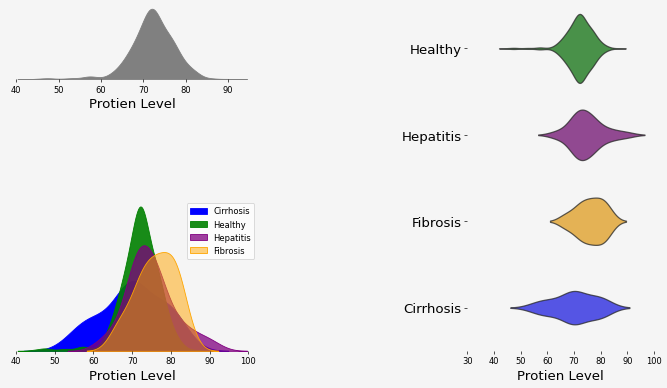

In [ ]:
#plots univariate analysis of PROT
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot('PROT', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,300])
ax1.set_xlabel('Protien Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot('PROT', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='blue',
            alpha=1, label='Cirrhosis', clip=[0,300])
sns.kdeplot('PROT', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,300])
sns.kdeplot('PROT', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,300])
sns.kdeplot('PROT', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,300])

ax2.legend()
ax2.set_xlabel('Protien Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='PROT', y='Category', data=data,  ax=ax3, aspect=2, inner=None)
ax3.set_xlim(30,100)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Georgia', 'fontsize':16 , 'color':'black'})
ax3.set_xlabel('Protien Level', {'font':'Georgia', 'fontsize':16 , 'color':'black'})
#--------------------------------------------------------



plt.show()

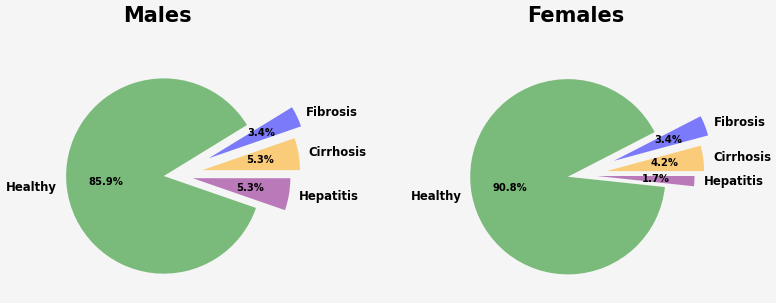

In [ ]:
#plots univariate analysis of Sex
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=13, nrows=5, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[:, 0:5])
ax2 = fig.add_subplot(gs[:, 8:])


# axes list
axes = [ ax1,ax2]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

#------------------------------------------------------------
#ax1
ax1_plot = ax1.pie(data[data.Sex == 'm'].groupby('Category').Category.count().values,
                   labels=data.groupby('Category').Category.count().index,
                    autopct='%1.1f%%', explode=[0.3,  0.4, 0.1, 0.2],
                   colors=['orange', 'blue', 'green', 'purple'])

for piece in ax1_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax1_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax1_plot[2]):
    text.set_weight('bold')
    text.set_size(12)


fig.text(0.1, 0.75, 'Males',  {'font':'Georgia',  'color': 'black', 'size':25})
#------------------------------------------------------------
#ax2
ax2_plot = ax2.pie(data[data.Sex == 'f'].groupby('Category').Category.count().values,
                   labels=data.groupby('Category').Category.count().index,
                    autopct='%1.1f%%', explode=[0.3,  0.4, 0.1, 0.2],
                   colors=['orange', 'blue', 'green', 'purple'])

for piece in ax2_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax2_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax2_plot[2]):
    text.set_weight('bold')
    text.set_size(12)

fig.text(0.38, 0.75, 'Females',  {'font':'Georgia',  'color': 'black', 'size':25})
#--------------------------------

plt.show()

<a id="32"></a>
# 3.2 Bivariate Analysis and Visualization of Dataset Features

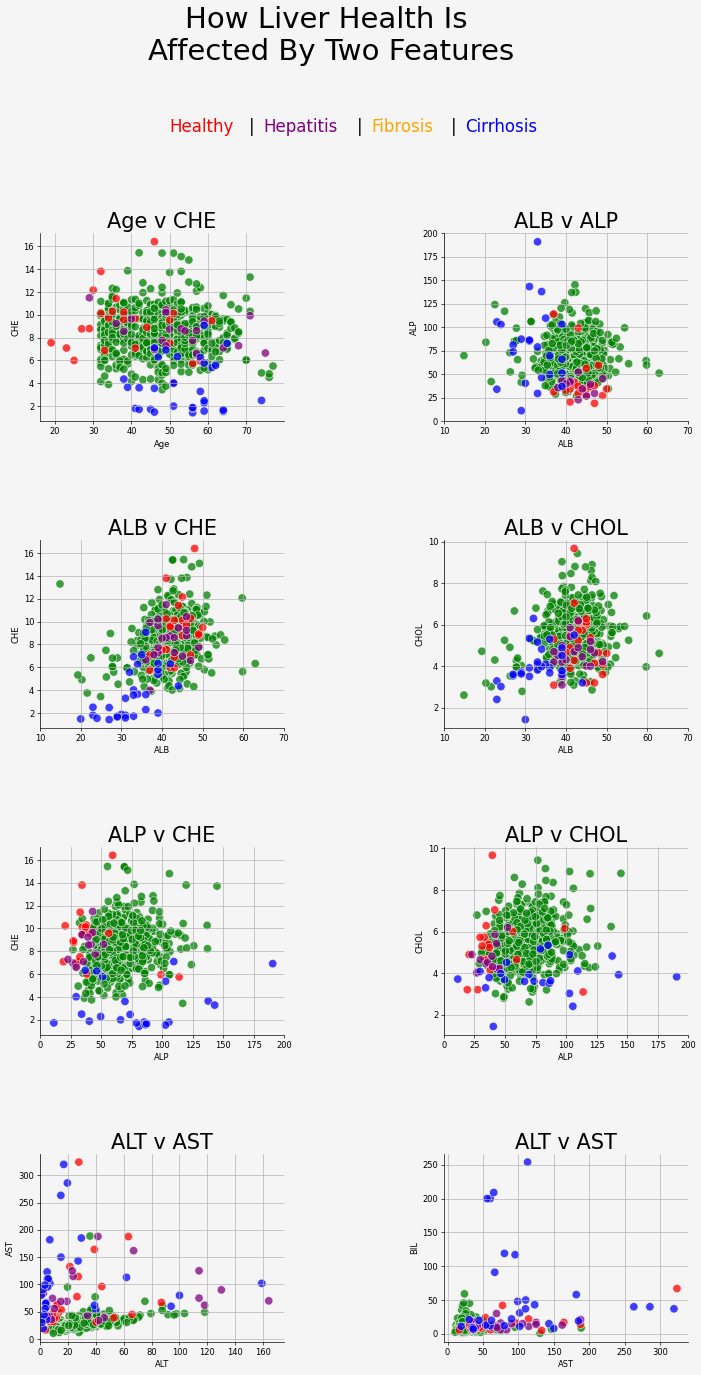

In [ ]:
#plots bivariate data
fig = plt.figure(figsize = (24,24), dpi = 60)
gs = GridSpec(ncols=13, nrows=29, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','red', 'purple', 'blue']))

ax1 = fig.add_subplot(gs[:5, :5])
ax2 = fig.add_subplot(gs[:5, 8:])
ax3 = fig.add_subplot(gs[8:13, :5])
ax4 = fig.add_subplot(gs[8:13, 8:])
ax5 = fig.add_subplot(gs[16:21, :5])
ax6 = fig.add_subplot(gs[16:21, 8:])
ax7 = fig.add_subplot(gs[24:, :5])
ax8 = fig.add_subplot(gs[24:, 8:])


# axes list
axes = [ ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.set_facecolor('#f5f5f5')
    ax.grid()

    for loc in ['right', 'top']:
        ax.spines[loc].set_visible(False)


#-------------------------------------------------------------------------------
#ax1 Age v CHE
sns.scatterplot(x='Age', y='CHE', hue='Category', data=data, ax=ax1, s=100, alpha=0.75, legend=None)
ax1.set_title('Age v CHE', {'font':'Georgia',  'color': 'black', 'size':25})
#-------------------------------------------------------------------------------
#ax2 ALB v ALP
sns.scatterplot(x='ALB', y='ALP', hue='Category', data=data, ax=ax2, s=100, alpha=0.75, legend=None)
ax2.set_title('ALB v ALP', {'font':'Georgia',  'color': 'black', 'size':25})
ax2.set_xlim(10, 70)
ax2.set_ylim(0,200)
#-------------------------------------------------------------------------------
#ax3 ALB v CHE
sns.scatterplot(x='ALB', y='CHE', hue='Category', data=data, ax=ax3, s=100, alpha=0.75, legend=None)
ax3.set_title('ALB v CHE', {'font':'Georgia',  'color': 'black', 'size':25})
ax3.set_xlim(10, 70)
#-------------------------------------------------------------------------------
#ax4 ALB v CHOL
sns.scatterplot(x='ALB', y='CHOL', hue='Category', data=data, ax=ax4, s=100, alpha=0.75, legend=None)
ax4.set_title('ALB v CHOL', {'font':'Georgia',  'color': 'black', 'size':25})
ax4.set_xlim(10, 70)
#-------------------------------------------------------------------------------
#ax5 ALP v CHE
sns.scatterplot(x='ALP', y='CHE', hue='Category', data=data, ax=ax5, s=100, alpha=0.75, legend=None)
ax5.set_title('ALP v CHE', {'font':'Georgia',  'color': 'black', 'size':25})
ax5.set_xlim(0, 200)
#-------------------------------------------------------------------------------
#ax6 ALP v CHOL
sns.scatterplot(x='ALP', y='CHOL', hue='Category', data=data, ax=ax6, s=100, alpha=0.75, legend=None)
ax6.set_title('ALP v CHOL', {'font':'Georgia',  'color': 'black', 'size':25})
ax6.set_xlim(0, 200)
#-------------------------------------------------------------------------------
#ax7 ALT v AST
sns.scatterplot(x='ALT', y='AST', hue='Category', data=data, ax=ax7, s=100, alpha=0.75, legend=None)
ax7.set_title('ALT v AST', {'font':'Georgia',  'color': 'black', 'size':25})
ax7.set_xlim(0, 175)
#-------------------------------------------------------------------------------
#ax8 AST v BIL
sns.scatterplot(x='AST', y='BIL', hue='Category', data=data, ax=ax8, s=100, alpha=0.75, legend=None)
ax8.set_title('ALT v AST', {'font':'Georgia',  'color': 'black', 'size':25})
#ax8.set_xlim(0, 175)


#-------------------------------------------
fig.text(0.1 + 0.04, 0.95, "Healthy",
         {'font':'Georgia',  'color': 'red', 'size':20})
fig.text(0.155 + 0.04, 0.95, "|",
         {'font':'Georgia',  'color': 'black', 'size':20})
fig.text(0.165 + 0.04, 0.95, "Hepatitis",
         {'font':'Georgia',  'color': 'purple', 'size':20})
fig.text(0.23 + 0.04, 0.95, "|",
         {'font':'Georgia',  'color': 'black', 'size':20})
fig.text(0.24 + 0.04, 0.95, "Fibrosis",
         {'font':'Georgia',  'color': 'orange', 'size':20})
fig.text(0.295 + 0.04, 0.95, "|",
         {'font':'Georgia',  'color': 'black', 'size':20})
fig.text(0.305 + 0.04, 0.95, "Cirrhosis",
         {'font':'Georgia',  'color': 'blue', 'size':20})


fig.text(0.125, 1, "    How Liver Health Is\nAffected By Two Features",
         {'font':'Georgia',  'color': 'black', 'size':35})
plt.show()

<a id="33"></a>
# 3.3 Multivariate Analysis and Visualization with PCA

In [ ]:
#creates lower dimension dataset to visualize multiple features at once
#first preprocess data
#sets Sex to 0 (m) or 1 (f)
gender_map = {'m': 0, 'f': 1}
data['Sex'] = data.Sex.map(gender_map)

#creates pipeline for data processing
ct = ColumnTransformer([
    ('scaler', StandardScaler(), [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
], remainder='passthrough')

knn_imp = KNNImputer(n_neighbors=5)

pipeline = Pipeline([
    ('scale', ct),
    ('impute', knn_imp)
])

X = pipeline.fit_transform(data.iloc[:, 1:].values)
y = data.Category.values

pca_1d = PCA(n_components=1)
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

X_1d = pca_1d.fit_transform(X).reshape(1,-1)[0]
X_2d = pca_2d.fit_transform(X).reshape(2, -1)
X_3d = pca_3d.fit_transform(X).reshape(3, -1)

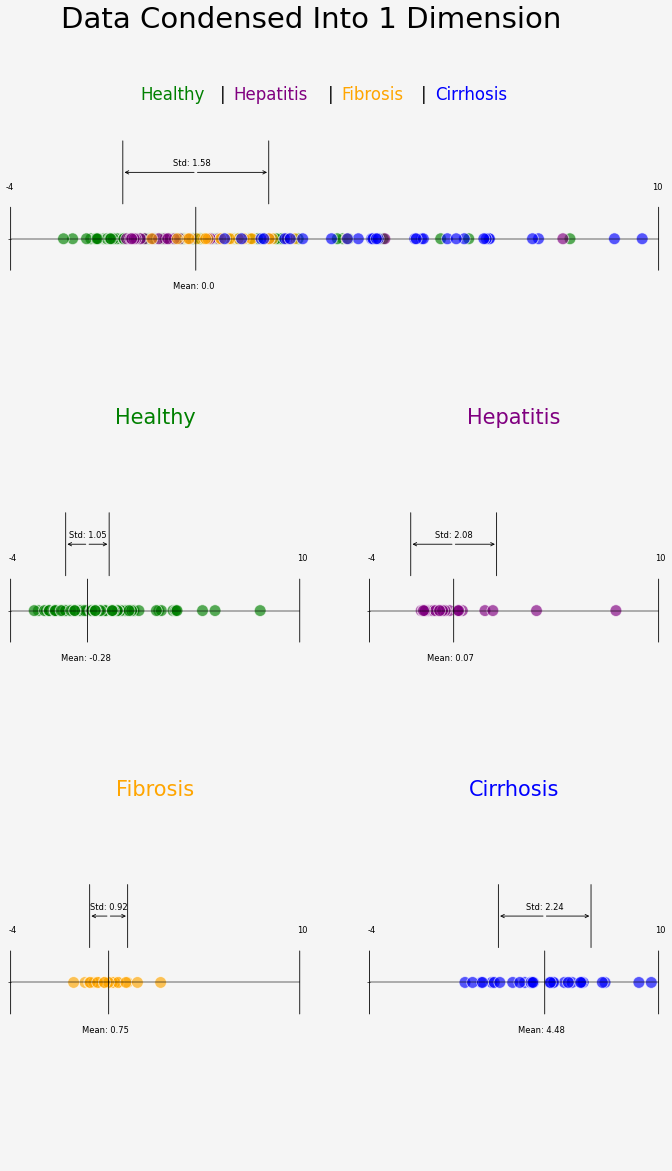

In [ ]:
#1d data
fig = plt.figure(figsize = (24,24), dpi = 60)
gs = GridSpec(ncols=11, nrows=15, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[:5, :])
ax2 = fig.add_subplot(gs[5:10, :5])
ax3 = fig.add_subplot(gs[5:10, 6:])
ax4 = fig.add_subplot(gs[10:, :5])
ax5 = fig.add_subplot(gs[10:, 6:])
# axes list
axes = [ ax1,ax2,ax3,ax4, ax5]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    #ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    ax.set_yticks([0], [''])
    ax.set_xticks([])
    ax.grid(color='black', lw=2., alpha=0.35)
    ax.set_xlim(-4, 10)
    ax.annotate("", xy=(-4, -0.01), xytext=(-4, 0.01),
                xycoords='data', arrowprops=dict(arrowstyle='-'))
    ax.annotate("", xy=(10, -0.01), xytext=(10, 0.01),
                xycoords='data', arrowprops=dict(arrowstyle='-'))
    ax.text(-4.1, 0.015, '-4')
    ax.text(9.85, 0.015, '10')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)


#-----------------------------------------------------------
#ax1
sns.scatterplot(x=X_1d, y=[0 for i in y], hue=y, s=200, alpha=0.65, ax=ax1, legend=False)
all_mean = X_1d.mean()
all_std = X_1d.std()
ax1.annotate("", xy=(all_mean, -0.01), xytext=(all_mean, 0.01),
            xycoords='data', arrowprops=dict(arrowstyle='-'))
ax1.text(all_mean - 0.5, -0.015, 'Mean: {}'.format(round(all_mean,2)))

ax1.annotate("", xy=(all_mean, 0.02), xytext=(all_mean-all_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax1.annotate("", xy=(all_mean-all_std, 0.01), xytext=(all_mean-all_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax1.annotate("", xy=(all_mean, 0.02), xytext=(all_mean+all_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax1.annotate("", xy=(all_mean+all_std, 0.01), xytext=(all_mean+all_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax1.text(all_mean - 0.5, 0.022, 'Std: {}'.format(round(all_std,2)))
#-----------------------------------------------------------
#ax2
healthy_ix  = [i for i in range(len(y)) if y[i] == 'Healthy']
sns.scatterplot(x=X_1d[healthy_ix], y=[0 for i in healthy_ix],  s=200,
                c=['green' for i in healthy_ix], alpha=0.65, ax=ax2, legend=False)
healthy_mean = X_1d[healthy_ix].mean()
healthy_std = X_1d[healthy_ix].std()
ax2.annotate("", xy=(healthy_mean, -0.01), xytext=(healthy_mean, 0.01),
            xycoords='data', arrowprops=dict(arrowstyle='-'))
ax2.text(healthy_mean - 1.3, -0.015, 'Mean: {}'.format(round(healthy_mean,2)))

ax2.annotate("", xy=(healthy_mean, 0.02), xytext=(healthy_mean-healthy_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax2.annotate("", xy=(healthy_mean-healthy_std, 0.01), xytext=(healthy_mean-healthy_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax2.annotate("", xy=(healthy_mean, 0.02), xytext=(healthy_mean+healthy_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax2.annotate("", xy=(healthy_mean+healthy_std, 0.01), xytext=(healthy_mean+healthy_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax2.text(healthy_mean - 0.9, 0.022, 'Std: {}'.format(round(healthy_std,2)))

ax2.set_title('Healthy', {'font':'Georgia',  'color': 'green', 'size':25})
#-----------------------------------------------------------
#ax3
hepatitis_ix  = [i for i in range(len(y)) if y[i] == 'Hepatitis']
sns.scatterplot(x=X_1d[hepatitis_ix], y=[0 for i in hepatitis_ix],  s=200,
                c=['purple' for i in hepatitis_ix], alpha=0.65, ax=ax3, legend=False)
hepatitis_mean = X_1d[hepatitis_ix].mean()
hepatitis_std = X_1d[hepatitis_ix].std()
ax3.annotate("", xy=(hepatitis_mean, -0.01), xytext=(hepatitis_mean, 0.01),
            xycoords='data', arrowprops=dict(arrowstyle='-'))
ax3.text(hepatitis_mean - 1.3, -0.015, 'Mean: {}'.format(round(hepatitis_mean,2)))

ax3.annotate("", xy=(hepatitis_mean, 0.02), xytext=(hepatitis_mean-hepatitis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax3.annotate("", xy=(hepatitis_mean-hepatitis_std, 0.01), xytext=(hepatitis_mean-hepatitis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax3.annotate("", xy=(hepatitis_mean, 0.02), xytext=(hepatitis_mean+hepatitis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax3.annotate("", xy=(hepatitis_mean+hepatitis_std, 0.01), xytext=(hepatitis_mean+hepatitis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax3.text(hepatitis_mean - 0.9, 0.022, 'Std: {}'.format(round(hepatitis_std,2)))

ax3.set_title('Hepatitis', {'font':'Georgia',  'color': 'purple', 'size':25})
#-----------------------------------------------------------
#ax4
fibrosis_ix  = [i for i in range(len(y)) if y[i] == 'Fibrosis']
sns.scatterplot(x=X_1d[fibrosis_ix], y=[0 for i in fibrosis_ix],  s=200,
                c=['orange' for i in fibrosis_ix], alpha=0.65, ax=ax4, legend=False)
fibrosis_mean = X_1d[fibrosis_ix].mean()
fibrosis_std = X_1d[fibrosis_ix].std()
ax4.annotate("", xy=(fibrosis_mean, -0.01), xytext=(fibrosis_mean, 0.01),
            xycoords='data', arrowprops=dict(arrowstyle='-'))
ax4.text(fibrosis_mean - 1.3, -0.015, 'Mean: {}'.format(round(fibrosis_mean,2)))

ax4.annotate("", xy=(fibrosis_mean, 0.02), xytext=(fibrosis_mean-fibrosis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax4.annotate("", xy=(fibrosis_mean-fibrosis_std, 0.01), xytext=(fibrosis_mean-fibrosis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax4.annotate("", xy=(fibrosis_mean, 0.02), xytext=(fibrosis_mean+fibrosis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax4.annotate("", xy=(fibrosis_mean+fibrosis_std, 0.01), xytext=(fibrosis_mean+fibrosis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax4.text(fibrosis_mean - 0.9, 0.022, 'Std: {}'.format(round(fibrosis_std,2)))

ax4.set_title('Fibrosis', {'font':'Georgia',  'color': 'orange', 'size':25})
#-----------------------------------------------------------
#ax5
cirrhosis_ix  = [i for i in range(len(y)) if y[i] == 'Cirrhosis']
sns.scatterplot(x=X_1d[cirrhosis_ix], y=[0 for i in cirrhosis_ix],  s=200,
                c=['blue' for i in cirrhosis_ix], alpha=0.65, ax=ax5, legend=False)
cirrhosis_mean = X_1d[cirrhosis_ix].mean()
cirrhosis_std = X_1d[cirrhosis_ix].std()
ax5.annotate("", xy=(cirrhosis_mean, -0.01), xytext=(cirrhosis_mean, 0.01),
            xycoords='data', arrowprops=dict(arrowstyle='-'))
ax5.text(cirrhosis_mean - 1.3, -0.015, 'Mean: {}'.format(round(cirrhosis_mean,2)))

ax5.annotate("", xy=(cirrhosis_mean, 0.02), xytext=(cirrhosis_mean-cirrhosis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax5.annotate("", xy=(cirrhosis_mean-cirrhosis_std, 0.01), xytext=(cirrhosis_mean-cirrhosis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax5.annotate("", xy=(cirrhosis_mean, 0.02), xytext=(cirrhosis_mean+cirrhosis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax5.annotate("", xy=(cirrhosis_mean+cirrhosis_std, 0.01), xytext=(cirrhosis_mean+cirrhosis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax5.text(cirrhosis_mean - 0.9, 0.022, 'Std: {}'.format(round(cirrhosis_std,2)))

ax5.set_title('Cirrhosis', {'font':'Georgia',  'color': 'blue', 'size':25})
#-----------------------------------------------------------

fig.text(0.1 + 0.04, 0.85, "Healthy",
         {'font':'Georgia',  'color': 'green', 'size':20})
fig.text(0.155 + 0.04, 0.85, "|",
         {'font':'Georgia',  'color': 'black', 'size':20})
fig.text(0.165 + 0.04, 0.85, "Hepatitis",
         {'font':'Georgia',  'color': 'purple', 'size':20})
fig.text(0.23 + 0.04, 0.85, "|",
         {'font':'Georgia',  'color': 'black', 'size':20})
fig.text(0.24 + 0.04, 0.85, "Fibrosis",
         {'font':'Georgia',  'color': 'orange', 'size':20})
fig.text(0.295 + 0.04, 0.85, "|",
         {'font':'Georgia',  'color': 'black', 'size':20})
fig.text(0.305 + 0.04, 0.85, "Cirrhosis",
         {'font':'Georgia',  'color': 'blue', 'size':20})
fig.text(0.085, 0.9, 'Data Condensed Into 1 Dimension', {'font':'Georgia',  'color': 'black', 'size':35})
plt.show()

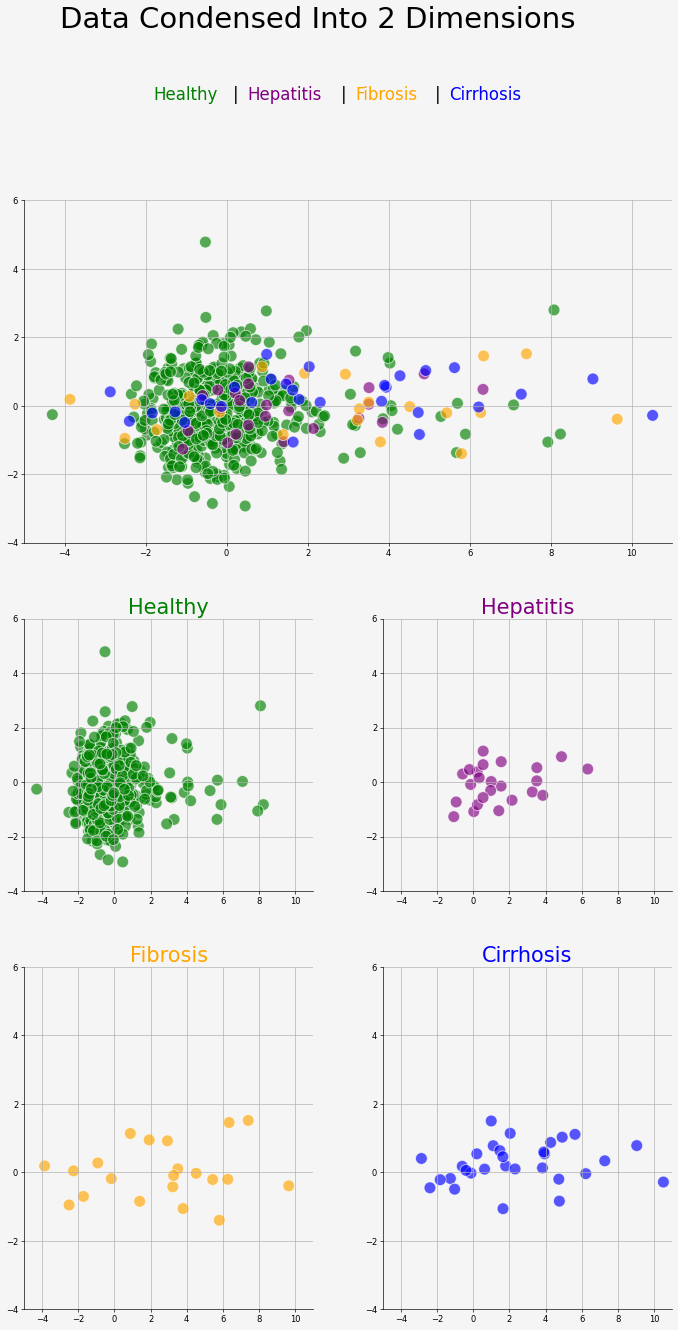

In [ ]:
#2d data
fig = plt.figure(figsize = (24,24), dpi = 60)
gs = GridSpec(ncols=11, nrows=16, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[:5, :])
ax2 = fig.add_subplot(gs[6:10, :5])
ax3 = fig.add_subplot(gs[6:10, 6:])
ax4 = fig.add_subplot(gs[11:, :5])
ax5 = fig.add_subplot(gs[11:, 6:])
# axes list
axes = [ ax1,ax2,ax3,ax4, ax5]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    #ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    ax.grid()
    ax.set_xlim(-5, 11)
    ax.set_ylim(-4, 6)
    for loc in ['right', 'top']:
        ax.spines[loc].set_visible(False)


#-----------------------------------------------------------
#ax1
sns.scatterplot(x=X_2d[1], y=X_2d[0], hue=y, s=200, alpha=0.65, ax=ax1, legend=False)

#-----------------------------------------------------------
#ax2
healthy_ix  = [i for i in range(len(y)) if y[i] == 'Healthy']
sns.scatterplot(x=X_2d[1][healthy_ix], y=X_2d[0][healthy_ix], s=200,
                c=['green' for i in healthy_ix], alpha=0.65, ax=ax2, legend=False)

ax2.set_title('Healthy', {'font':'Georgia',  'color': 'green', 'size':25})
#-----------------------------------------------------------
#ax3
hepatitis_ix  = [i for i in range(len(y)) if y[i] == 'Hepatitis']
sns.scatterplot(x=X_2d[1][hepatitis_ix], y=X_2d[0][hepatitis_ix], s=200,
                c=['purple' for i in hepatitis_ix], alpha=0.65, ax=ax3, legend=False)


ax3.set_title('Hepatitis', {'font':'Georgia',  'color': 'purple', 'size':25})
#-----------------------------------------------------------
#ax4
fibrosis_ix  = [i for i in range(len(y)) if y[i] == 'Fibrosis']
sns.scatterplot(x=X_2d[1][fibrosis_ix], y=X_2d[0][fibrosis_ix], s=200,
                c=['orange' for i in fibrosis_ix], alpha=0.65, ax=ax4, legend=False)


ax4.set_title('Fibrosis', {'font':'Georgia',  'color': 'orange', 'size':25})
#-----------------------------------------------------------
#ax5
cirrhosis_ix  = [i for i in range(len(y)) if y[i] == 'Cirrhosis']
sns.scatterplot(x=X_2d[1][cirrhosis_ix], y=X_2d[0][cirrhosis_ix], s=200,
                c=['blue' for i in cirrhosis_ix], alpha=0.65, ax=ax5, legend=False)

ax5.set_title('Cirrhosis', {'font':'Georgia',  'color': 'blue', 'size':25})
#-----------------------------------------------------------

fig.text(0.1 + 0.04, 0.95, "Healthy",
         {'font':'Georgia',  'color': 'green', 'size':20})
fig.text(0.155 + 0.04, 0.95, "|",
         {'font':'Georgia',  'color': 'black', 'size':20})
fig.text(0.165 + 0.04, 0.95, "Hepatitis",
         {'font':'Georgia',  'color': 'purple', 'size':20})
fig.text(0.23 + 0.04, 0.95, "|",
         {'font':'Georgia',  'color': 'black', 'size':20})
fig.text(0.24 + 0.04, 0.95, "Fibrosis",
         {'font':'Georgia',  'color': 'orange', 'size':20})
fig.text(0.295 + 0.04, 0.95, "|",
         {'font':'Georgia',  'color': 'black', 'size':20})
fig.text(0.305 + 0.04, 0.95, "Cirrhosis",
         {'font':'Georgia',  'color': 'blue', 'size':20})
fig.text(0.075, 1, 'Data Condensed Into 2 Dimensions', {'font':'Georgia',  'color': 'black', 'size':35})
plt.show()

<a id="4"></a>
# 4. Balance Dataset with SMOTE

In [ ]:
#converts y to float values
y_float = np.where(y=='Healthy', 0.0, y)
y_float = np.where(y_float=='Hepatitis', 1.0, y_float)
y_float = np.where(y_float=='Fibrosis', 2.0, y_float)
y_float = np.where(y_float=='Cirrhosis', 3.0, y_float).astype('float64')
#splits data into train, validation, and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_float, test_size=0.3, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=8)
#SMOTE for class balancing
sm = SMOTE(random_state=8)

#create new training set with SMOTE object
X_bal, y_bal = sm.fit_resample(X_train, y_train)

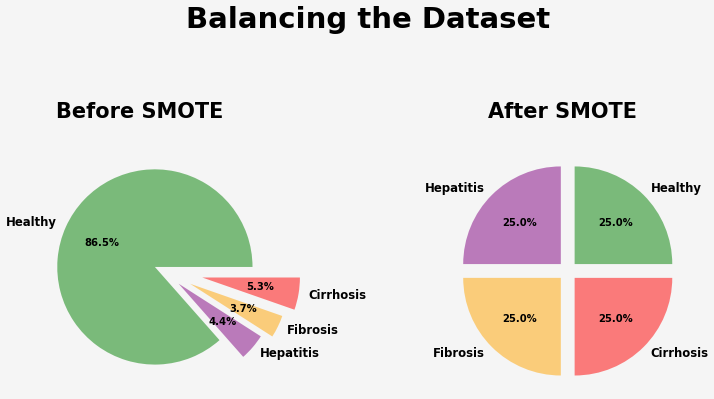

In [ ]:
#plots target data
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=13, nrows=5, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'blue']))

ax1 = fig.add_subplot(gs[:, 0:5])
ax2 = fig.add_subplot(gs[:, 8:])


# axes list
axes = [ ax1,ax2]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

#------------------------------------------------------------
#ax1
pre_smote_count = [len(y_train[y_train==0.0]), len(y_train[y_train==1.0]),
                  len(y_train[y_train==2.0]), len(y_train[y_train==3.0])]
ax1_plot = ax1.pie(pre_smote_count,
                   labels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                    autopct='%1.1f%%', explode=[0.1,  0.2, 0.3, 0.4],
                   colors=['green', 'purple', 'orange', 'blue'])

for piece in ax1_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax1_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax1_plot[2]):
    text.set_weight('bold')
    text.set_size(12)


fig.text(0.06, 0.75, 'Before SMOTE',  {'font':'Georgia',  'color': 'black', 'size':25})
#------------------------------------------------------------
#ax2
post_smote_count = [len(y_bal[y_bal==0.0]), len(y_bal[y_bal==1.0]),
                  len(y_bal[y_bal==2.0]), len(y_bal[y_bal==3.0])]
ax2_plot = ax2.pie(post_smote_count,
                   labels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                    autopct='%1.1f%%', explode=[0.1,  0.1, 0.1, 0.1],
                   colors=['green', 'purple', 'orange', 'blue'])

for piece in ax2_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax2_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax2_plot[2]):
    text.set_weight('bold')
    text.set_size(12)

fig.text(0.36, 0.75, 'After SMOTE',  {'font':'Georgia',  'color': 'black', 'size':25})
#--------------------------------
fig.text(0.15, 0.9, 'Balancing the Dataset',
         {'font':'Georgia',  'color': 'black', 'size':35})
plt.show()

<a id="5"></a>
# 5. Model Creation and Hyperparameter Optimization with OPTUNA

In [ ]:
# OPTUNA objective function
import optuna
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
def objective(trial):
    #------------------------------
    #logistic regression
    lr_penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2', 'elasticnet'])
    lr_l1_ratio = None
    if lr_penalty == 'l1':
        lr_solver = trial.suggest_categorical('lr_solver1', ['liblinear', 'saga'])
    elif lr_penalty == 'l2':
        lr_solver = trial.suggest_categorical('lr_solver2', ['newton-cg', 'lbfgs', 'sag', 'liblinear', 'saga'])
    else:
        lr_solver = 'saga'
        lr_l1_ratio = trial.suggest_uniform('lr_l1_ratio', 0.0, 1.0)

    lr_tol = trial.suggest_uniform('lr_tol', 1e-5, 1e-2)
    lr_C = trial.suggest_uniform('lr_C', 0.0, 1.0)

    lr = LogisticRegression(
        penalty=lr_penalty,
        tol=lr_tol,
        C=lr_C,
        solver=lr_solver,
        l1_ratio=lr_l1_ratio
    )


    #----------------------------------------------------------
    #KNN
    knn_neighbors = trial.suggest_int('knn_neighbors', 2, 100)
    knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
    knn_p = trial.suggest_categorical('knn_p', [1, 2])

    knn = KNeighborsClassifier(
        n_neighbors=knn_neighbors,
        weights=knn_weights,
        p=knn_p
    )


    #----------------------------------------------------------
    #SVM
    svm_C = trial.suggest_uniform('svm_C', 0.0, 1.0)
    svm_kernel = trial.suggest_categorical('svm_kernel', ['poly', 'rbf'])
    svm_degree = 3
    if svm_kernel == 'poly':
        svm_degree = trial.suggest_int('svm_degree', 1, 10)
    svm_tol = trial.suggest_uniform('svm_tol', 1e-5, 1e-2)

    svm = SVC(
        C=svm_C,
        kernel=svm_kernel,
        degree=svm_degree,
        tol=svm_tol
    )

    #-----------------------------------------------------------
    #random forest
    rf_estimators = trial.suggest_int('rf_estimators', 1, 500)
    rf_criterion = trial.suggest_categorical('rf_criterion', ['entropy', 'gini'])
    rf_max_depth = trial.suggest_int('rf_max_depth', 1, 100)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 50)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 25)

    rf = RandomForestClassifier(
        n_estimators=rf_estimators,
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf
    )


    #---------------------------------------------------------
    #naive bayes
    nb_smoothing = trial.suggest_uniform('nb_smoothing', 1e-10, 1e-6)
    nb = GaussianNB(var_smoothing=nb_smoothing)


   #---------------------------------------------------------
    # XGBoost Classifier
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 1, 10)
    xgb_learning_rate = trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.5)
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 500)
    xgb_gamma = trial.suggest_loguniform('xgb_gamma', 0.01, 1.0)

    xgb = XGBClassifier(
        max_depth=xgb_max_depth,
        learning_rate=xgb_learning_rate,
        n_estimators=xgb_n_estimators,
        gamma=xgb_gamma,
        random_state=42
    )

    #---------------------------------------------------------
    # Multi-Layer Perceptron (MLP)
    mlp_hidden_layer_sizes = trial.suggest_categorical('mlp_hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50), (100, 100)])
    mlp_activation = trial.suggest_categorical('mlp_activation', ['logistic', 'tanh', 'relu'])
    mlp_solver = trial.suggest_categorical('mlp_solver', ['adam', 'lbfgs', 'sgd'])
    mlp_alpha = trial.suggest_uniform('mlp_alpha', 0.0001, 0.01)

    mlp = MLPClassifier(
        hidden_layer_sizes=mlp_hidden_layer_sizes,
        activation=mlp_activation,
        solver=mlp_solver,
        alpha=mlp_alpha,
        random_state=42
    )


    # Ensemble model
    lr_w = trial.suggest_uniform('lr_w', 0.0, 1.0)
    knn_w = trial.suggest_uniform('knn_w', 0.0, 1.0)
    svm_w = trial.suggest_uniform('svm_w', 0.0, 1.0)
    rf_w = trial.suggest_uniform('rf_w', 0.0, 1.0)
    nb_w = trial.suggest_uniform('nb_w', 0.0, 1.0)
    xgb_w = trial.suggest_uniform('xgb_w', 0.0, 1.0)
    mlp_w = trial.suggest_uniform('mlp_w', 0.0, 1.0)

    vc = VotingClassifier(estimators=[
        ('lr', lr),
        ('knn', knn),
        ('svm', svm),
        ('rf', rf),
        ('nb', nb),
        ('xgb', xgb),
        ('mlp', mlp)
    ],
    weights=[lr_w, knn_w, svm_w, rf_w, nb_w, xgb_w, mlp_w]  # Adjusting weights accordingly
    )

    vc.fit(X_bal, y_bal)
    pblues = vc.pblueict(X_val)

    acc = metrics.accuracy_score(y_val, pblues)

    return acc

In [ ]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

NameError: ignored

In [ ]:
print('===========================================================')
print('Model Accuracy on Valadation Set:', round(study.best_trial.values[0], 2))
print('===========================================================')
print('Best Hyperparameters:')
print('===========================================================')
print(study.best_params)

ValueError: ignored

In [ ]:
#recreates a model from the best hyperparameters:
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier


def create_model(best_params):
        #------------------------------
    try:
        l1_ratio = best_params['lr_l1_ratio']
    except:
        l1_ratio = None
    try:
        solver = best_params['lr_solver1']
    except:
        try:
            solver = best_params['lr_solver2']
        except:
            solver = 'saga'

    lr = LogisticRegression(
        penalty=best_params['lr_penalty'],
        tol=best_params['lr_tol'],
        C=best_params['lr_C'],
        l1_ratio=l1_ratio,
        solver=solver
    )


    #----------------------------------------------------------
    #KNN

    knn = KNeighborsClassifier(
        n_neighbors=best_params['knn_neighbors'],
        weights=best_params['knn_weights'],
        p=best_params['knn_p']
    )


    #----------------------------------------------------------
    #SVM

    svm = SVC(
        C=best_params['svm_C'],
        kernel=best_params['svm_kernel'],
        degree=best_params['svm_degree'],
        tol=best_params['svm_tol']
    )

    #-----------------------------------------------------------
    #random forest
    rf = RandomForestClassifier(
        n_estimators=best_params['rf_estimators'],
        criterion=best_params['rf_criterion'],
        max_depth=best_params['rf_max_depth'],
        min_samples_split=best_params['rf_min_samples_split'],
        min_samples_leaf=best_params['rf_min_samples_leaf']
    )


    #---------------------------------------------------------
    #naive bayes
    nb = GaussianNB(var_smoothing=best_params['nb_smoothing'])


    #-----------------------------------------------------------
    # Extra Trees Classifier
    extra_trees_n_estimators = best_params['extra_trees_n_estimators']
    extra_trees_criterion = best_params['extra_trees_criterion']
    extra_trees_max_depth = best_params['extra_trees_max_depth']

    extra_trees = ExtraTreesClassifier(
                  n_estimators=extra_trees_n_estimators,
                  criterion=extra_trees_criterion,
                  max_depth=extra_trees_max_depth
)

    #-----------------------------------------------------------
    # MLP
    mlp_hidden_layer_sizes = best_params['mlp_hidden_layer_sizes']
    mlp_activation = best_params['mlp_activation']
    mlp_solver = best_params['mlp_solver']
    mlp_alpha = best_params['mlp_alpha']

    mlp = MLPClassifier(
        hidden_layer_sizes=mlp_hidden_layer_sizes,
        activation=mlp_activation,
        solver=mlp_solver,
        alpha=mlp_alpha
    )

    #ensemble model
    vc = VotingClassifier(estimators=[
        ('lr', lr),
        ('knn', knn),
        ('svm', svm),
        ('rf', rf),
        ('nb', nb),
        ('mlp', mlp),
        ('extra_trees', extra_trees)],
                          weights=[
                              best_params['lr_w'],
                              best_params['knn_w'],
                              best_params['svm_w'],
                              best_params['rf_w'],
                              best_params['nb_w'],
                              best_params['mlp_w'],
                              best_params['extra_trees_w'] ]
                         )

    vc.fit(X_bal, y_bal)

    return vc

In [ ]:
#ensemble model with best hyperparameters
model = create_model(study.best_params)

<a id="6"></a>
# 6. Model Evaluation on Test Set and Explination with SHAP

In [ ]:
#creates shap explainer
feature_names = list(data.columns)[1:2] + list(data.columns)[3:] + [list(data.columns)[2]]
explainer = shap.Explainer(model.pblueict, X_train, feature_names=feature_names)
shap_values = explainer(X_test)

In [ ]:
#plots importance of each feature
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
#plots importance of each feature
shap.summary_plot(shap_values, X_test)

In [ ]:
#plots effect of the AST feature
shap.partial_dependence_plot(4, model.pblueict, X_test, feature_names=feature_names)

In [ ]:
#displays the final evaluation
test_pblues = model.pblueict(X_test)
print('Test Accuracy:', round(metrics.accuracy_score(y_test, test_pblues), 4))

<a id="7"></a>
# 7. Conclusion

<ul>
    <li><strong>The amount of certain protiens and amino acids in the patient's blood is a good indicator to their risk of liver disease.</strong> This is especially true for certain combinations of these items as we have seen in the bivariate analysis section.</li>
    <li><strong>The amount of aspartate aminotransferase in a patient's blood contributes significantly more to the ensemble model than any other feature.</strong> As shown in the SHAP graphs, the greater the AST level, the higher chance of being classified as having a liver disease.</li>
    <li><strong>The final model has an accuracy of about 95% on test data.</strong> The model is an voting ensemble of 5 models: logistic regression, k-nearest neighbors, support vector machine, random forest and naive bayes. Random forest and logistic regressing take up a majority of the vote.</li>
</ul>

In [ ]:
# OPTUNA objective function
def objective(trial):
    #------------------------------
    #logistic regression
    lr_penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2', 'elasticnet'])
    lr_l1_ratio = None
    if lr_penalty == 'l1':
        lr_solver = trial.suggest_categorical('lr_solver1', ['liblinear', 'saga'])
    elif lr_penalty == 'l2':
        lr_solver = trial.suggest_categorical('lr_solver2', ['newton-cg', 'lbfgs', 'sag', 'liblinear', 'saga'])
    else:
        lr_solver = 'saga'
        lr_l1_ratio = trial.suggest_uniform('lr_l1_ratio', 0.0, 1.0)

    lr_tol = trial.suggest_uniform('lr_tol', 1e-5, 1e-2)
    lr_C = trial.suggest_uniform('lr_C', 0.0, 1.0)

    lr = LogisticRegression(
        penalty=lr_penalty,
        tol=lr_tol,
        C=lr_C,
        solver=lr_solver,
        l1_ratio=lr_l1_ratio
    )


    #----------------------------------------------------------
    #KNN
    knn_neighbors = trial.suggest_int('knn_neighbors', 2, 100)
    knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
    knn_p = trial.suggest_categorical('knn_p', [1, 2])

    knn = KNeighborsClassifier(
        n_neighbors=knn_neighbors,
        weights=knn_weights,
        p=knn_p
    )


    #----------------------------------------------------------
    #SVM
    svm_C = trial.suggest_uniform('svm_C', 0.0, 1.0)
    svm_kernel = trial.suggest_categorical('svm_kernel', ['poly', 'rbf'])
    svm_degree = 3
    if svm_kernel == 'poly':
        svm_degree = trial.suggest_int('svm_degree', 1, 10)
    svm_tol = trial.suggest_uniform('svm_tol', 1e-5, 1e-2)

    svm = SVC(
        C=svm_C,
        kernel=svm_kernel,
        degree=svm_degree,
        tol=svm_tol
    )

    #-----------------------------------------------------------
    #random forest
    rf_estimators = trial.suggest_int('rf_estimators', 1, 500)
    rf_criterion = trial.suggest_categorical('rf_criterion', ['entropy', 'gini'])
    rf_max_depth = trial.suggest_int('rf_max_depth', 1, 100)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 50)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 25)

    rf = RandomForestClassifier(
        n_estimators=rf_estimators,
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf
    )


    #---------------------------------------------------------
    #naive bayes
    nb_smoothing = trial.suggest_uniform('nb_smoothing', 1e-10, 1e-6)
    nb = GaussianNB(var_smoothing=nb_smoothing)


    #---------------------------------------------------------

    #ensemble model
    lr_w = trial.suggest_uniform('lr_w', 0.0, 1.0)
    knn_w = trial.suggest_uniform('knn_w', 0.0, 1.0)
    svm_w = trial.suggest_uniform('svm_w', 0.0, 1.0)
    rf_w = trial.suggest_uniform('rf_w', 0.0, 1.0)
    nb_w = trial.suggest_uniform('nb_w', 0.0, 1.0)


    vc = VotingClassifier(estimators=[
        ('lr', lr),
        ('knn', knn),
        ('svm', svm),
        ('rf', rf),
        ('nb', nb)],
                          weights=[lr_w, knn_w, svm_w, rf_w, nb_w]
                         )

    vc.fit(X_bal, y_bal)
    pblues = vc.pblueict(X_val)

    acc = metrics.accuracy_score(y_val, pblues)

    return acc

In [ ]:
def objective(trial):
    #------------------------------
    #logistic regression
    lr_penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2', 'elasticnet'])
    lr_l1_ratio = None
    if lr_penalty == 'l1':
        lr_solver = trial.suggest_categorical('lr_solver1', ['liblinear', 'saga'])
    elif lr_penalty == 'l2':
        lr_solver = trial.suggest_categorical('lr_solver2', ['newton-cg', 'lbfgs', 'sag', 'liblinear', 'saga'])
    else:
        lr_solver = 'saga'
        lr_l1_ratio = trial.suggest_uniform('lr_l1_ratio', 0.0, 1.0)

    lr_tol = trial.suggest_uniform('lr_tol', 1e-5, 1e-2)
    lr_C = trial.suggest_uniform('lr_C', 0.0, 1.0)

    lr = LogisticRegression(
        penalty=lr_penalty,
        tol=lr_tol,
        C=lr_C,
        solver=lr_solver,
        l1_ratio=lr_l1_ratio
    )


    #----------------------------------------------------------
    #KNN
    knn_neighbors = trial.suggest_int('knn_neighbors', 2, 100)
    knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
    knn_p = trial.suggest_categorical('knn_p', [1, 2])

    knn = KNeighborsClassifier(
        n_neighbors=knn_neighbors,
        weights=knn_weights,
        p=knn_p
    )


    #----------------------------------------------------------
    #SVM
    svm_C = trial.suggest_uniform('svm_C', 0.0, 1.0)
    svm_kernel = trial.suggest_categorical('svm_kernel', ['poly', 'rbf'])
    svm_degree = 3
    if svm_kernel == 'poly':
        svm_degree = trial.suggest_int('svm_degree', 1, 10)
    svm_tol = trial.suggest_uniform('svm_tol', 1e-5, 1e-2)

    svm = SVC(
        C=svm_C,
        kernel=svm_kernel,
        degree=svm_degree,
        tol=svm_tol
    )

    #-----------------------------------------------------------
    #random forest
    rf_estimators = trial.suggest_int('rf_estimators', 1, 500)
    rf_criterion = trial.suggest_categorical('rf_criterion', ['entropy', 'gini'])
    rf_max_depth = trial.suggest_int('rf_max_depth', 1, 100)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 50)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 25)

    rf = RandomForestClassifier(
        n_estimators=rf_estimators,
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf
    )

    #---------------------------------------------------------
    #naive bayes
    nb_smoothing = trial.suggest_uniform('nb_smoothing', 1e-10, 1e-6)
    nb = GaussianNB(var_smoothing=nb_smoothing)

    #-----------------------------------------------------------
    # Extra Trees Classifier
    extra_trees_n_estimators = trial.suggest_int('extra_trees_n_estimators', 50, 500)
    extra_trees_criterion = trial.suggest_categorical('extra_trees_criterion', ['gini', 'entropy'])
    extra_trees_max_depth = trial.suggest_int('extra_trees_max_depth', 1, 100)

    extra_trees = ExtraTreesClassifier(
        n_estimators=extra_trees_n_estimators,
        criterion=extra_trees_criterion,
        max_depth=extra_trees_max_depth
    )

    #-----------------------------------------------------------
    # MLP
    mlp_hidden_layer_sizes = trial.suggest_int('mlp_hidden_layer_sizes', 1, 100)
    mlp_activation = trial.suggest_categorical('mlp_activation', ['relu', 'tanh', 'logistic'])
    mlp_solver = trial.suggest_categorical('mlp_solver', ['adam', 'sgd', 'lbfgs'])
    mlp_alpha = trial.suggest_loguniform('mlp_alpha', 1e-5, 1e-1)

    mlp = MLPClassifier(
        hidden_layer_sizes=(mlp_hidden_layer_sizes,),
        activation=mlp_activation,
        solver=mlp_solver,
        alpha=mlp_alpha
    )

    #ensemble model
    lr_w = trial.suggest_uniform('lr_w', 0.0, 1.0)
    knn_w = trial.suggest_uniform('knn_w', 0.0, 1.0)
    svm_w = trial.suggest_uniform('svm_w', 0.0, 1.0)
    rf_w = trial.suggest_uniform('rf_w', 0.0, 1.0)
    nb_w = trial.suggest_uniform('nb_w', 0.0, 1.0)
    extra_trees_w = trial.suggest_uniform('extra_trees_w', 0.0, 1.0)
    mlp_w = trial.suggest_uniform('mlp_w', 0.0, 1.0)

    vc = VotingClassifier(estimators=[
        ('lr', lr),
        ('knn', knn),
        ('svm', svm),
        ('rf', rf),
        ('nb', nb),
        ('extra_trees', extra_trees),
        ('mlp', mlp)
    ], weights=[lr_w, knn_w, svm_w, rf_w, nb_w, extra_trees_w, mlp_w])

    vc.fit(X_bal, y_bal)
    pblues = vc.pblueict(X_val)

    acc = metrics.accuracy_score(y_val, pblues)

    return acc

# Assuming you have defined X_bal, y_bal, X_val, and y_val before running the optimization

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Access the best hyperparameters found
best_params = study.best_params

# Use the best hyperparameters to build the final ensemble model
best_vc = VotingClassifier(estimators=[
    ('lr', LogisticRegression(**best_params)),
    ('knn', KNeighborsClassifier(**best_params)),
    ('svm', SVC(**best_params)),
    ('rf', RandomForestClassifier(**best_params)),
    ('nb', GaussianNB(**best_params)),
    ('extra_trees', ExtraTreesClassifier(**best_params)),
    ('mlp', MLPClassifier(**best_params))
], weights=[best_params['lr_w'], best_params['knn_w'], best_params['svm_w'],
            best_params['rf_w'], best_params['nb_w'], best_params['extra_trees_w'],
            best_params['mlp_w']])

best_vc.fit(X_bal, y_bal)
pblues_test = best_vc.pblueict(X_test)
test_accuracy = metrics.accuracy_score(y_test, pblues_test)

print("Best Test Accuracy:", test_accuracy)
In this code, I have added the Extra Trees Classifier and the MLP Classifier to the ensemble model, and also fixed the issue with the Logistic Regression parameter names. The code should now work as expected.








In [ ]:
# OPTUNA objective function
def objective(trial):
    #------------------------------
    #logistic regression
    lr_penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2', 'elasticnet'])
    lr_l1_ratio = None
    if lr_penalty == 'l1':
        lr_solver = trial.suggest_categorical('lr_solver1', ['liblinear', 'saga'])
    elif lr_penalty == 'l2':
        lr_solver = trial.suggest_categorical('lr_solver2', ['newton-cg', 'lbfgs', 'sag', 'liblinear', 'saga'])
    else:
        lr_solver = 'saga'
        lr_l1_ratio = trial.suggest_uniform('lr_l1_ratio', 0.0, 1.0)

    lr_tol = trial.suggest_uniform('lr_tol', 1e-5, 1e-2)
    lr_C = trial.suggest_uniform('lr_C', 0.0, 1.0)

    lr = LogisticRegression(
        penalty=lr_penalty,
        tol=lr_tol,
        C=lr_C,
        solver=lr_solver,
        l1_ratio=lr_l1_ratio
    )


    #----------------------------------------------------------
    #KNN
    knn_neighbors = trial.suggest_int('knn_neighbors', 2, 100)
    knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
    knn_p = trial.suggest_categorical('knn_p', [1, 2])

    knn = KNeighborsClassifier(
        n_neighbors=knn_neighbors,
        weights=knn_weights,
        p=knn_p
    )


    #----------------------------------------------------------
    #SVM
    svm_C = trial.suggest_uniform('svm_C', 0.0, 1.0)
    svm_kernel = trial.suggest_categorical('svm_kernel', ['poly', 'rbf'])
    svm_degree = 3
    if svm_kernel == 'poly':
        svm_degree = trial.suggest_int('svm_degree', 1, 10)
    svm_tol = trial.suggest_uniform('svm_tol', 1e-5, 1e-2)

    svm = SVC(
        C=svm_C,
        kernel=svm_kernel,
        degree=svm_degree,
        tol=svm_tol
    )

    #-----------------------------------------------------------
    #random forest
    rf_estimators = trial.suggest_int('rf_estimators', 1, 500)
    rf_criterion = trial.suggest_categorical('rf_criterion', ['entropy', 'gini'])
    rf_max_depth = trial.suggest_int('rf_max_depth', 1, 100)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 50)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 25)

    rf = RandomForestClassifier(
        n_estimators=rf_estimators,
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf
    )


    #---------------------------------------------------------
    #naive bayes
    nb_smoothing = trial.suggest_uniform('nb_smoothing', 1e-10, 1e-6)
    nb = GaussianNB(var_smoothing=nb_smoothing)


    #---------------------------------------------------------

    #ensemble model
    lr_w = trial.suggest_uniform('lr_w', 0.0, 1.0)
    knn_w = trial.suggest_uniform('knn_w', 0.0, 1.0)
    svm_w = trial.suggest_uniform('svm_w', 0.0, 1.0)
    rf_w = trial.suggest_uniform('rf_w', 0.0, 1.0)
    nb_w = trial.suggest_uniform('nb_w', 0.0, 1.0)


    vc = VotingClassifier(estimators=[
        ('lr', lr),
        ('knn', knn),
        ('svm', svm),
        ('rf', rf),
        ('nb', nb)],
                          weights=[lr_w, knn_w, svm_w, rf_w, nb_w]
                         )

    vc.fit(X_bal, y_bal)
    pblues = vc.pblueict(X_val)

    acc = metrics.accuracy_score(y_val, pblues)

    return acc